# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:

- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demonstrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.
- apresentar um método para aumentar a resolução (*shift-and-stitch*)

## Motivação

### Rede 2 camadas convolucionais e 2 camadas densas

<img src='../figures/Rede_LeNet_like.png', width=800pt></img>

### Rede equivalente com 4 camadas convolucionais 

<img src='../figures/Rede_LeNet_like_fully_convolutional.png', width=800pt></img>

## Importando os módulos

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import time
import numpy as np
import argparse

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout

from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback
from keras.utils import np_utils

import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')

sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)


Using TensorFlow backend.


In [3]:
print('Backend:     {}'.format(K.backend()))
print('Data format: {}'.format(K.image_data_format()))

print('Keras ', keras.__version__)
print('Numpy ', np.__version__)

Backend:     tensorflow
Data format: channels_first
Keras  2.0.3
Numpy  1.12.1


## Função padrão para auxiliar o treinamento

In [4]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=batch_size, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass
    model, cb = load_model_and_history(model_name)
    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

## Carregando MNIST dataset

In [5]:
H = W = 28
n_classes = 10
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, H, W) / 255.0
X_test = X_test.reshape(-1, 1, H, W) / 255.0

y_train_oh = np_utils.to_categorical(y_train, 10)
y_test_oh = np_utils.to_categorical(y_test, 10)

print(X_train.shape, y_train_oh.shape)
print(X_test.shape, y_test_oh.shape)

(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)


## Pequena amostra apenas para testar o código

In [6]:
n_samples_train = 1000
n_samples_test  = 500

X_train = X_train[:n_samples_train]
y_train_oh = y_train_oh[:n_samples_train]
X_test = X_test[:n_samples_test]
y_test = y_test[:n_samples_test]
y_test_oh = y_test_oh[:n_samples_test]

print(X_train.shape, y_train_oh.shape)
print(X_test.shape, y_test_oh.shape)

(1000, 1, 28, 28) (1000, 10)
(500, 1, 28, 28) (500, 10)


## Carregando nosso modelo pre-treinado anteriormente

Iremos converter a rede já treinada no exemplo anterior. Caso a próxima célula deste notebook
der erro, é muito provável que o modelo da rede não foi salvo. Deve-se portanto executar o notebook:

- [keras-lenet-mnist.ipynb](keras-lenet-mnist.ipynb)

In [7]:
print("[INFO] loading model...")
model_name = '../../models/keras_lenet_1'
model_A, histo_A = load_model_and_history(model_name)  # Modelo A é a rede do exercício anterior, com camadas densas no final

model_A.summary()

[INFO] loading model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 7, 7)       

In [8]:
test_network(model_name, X_test, y_test_oh)

Model from epoch 16
[INFO] evaluating in the test data set ...
500/500 [==============================] - 0s     

[INFO] accuracy on the test data set: 96.80% [0.10784]


## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 50. Seus pesos têm portanto dimensão 2450x50.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 50x1x1, a convolução deve criar 50 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


### Observando o shape dos pesos da rede original

O Keras adota a seguinte convenção para o *shape* dos kernels das camadas convolucionais, usando o modelo "channels_first":

 - (wh, ww, channels,nb_filters):

In [9]:
W_all_A = model_A.get_weights()
params = [w.shape for w in W_all_A]
print(params)

[(5, 5, 1, 20), (20,), (5, 5, 20, 50), (50,), (2450, 50), (50,), (50, 10), (10,)]


Observe que não 4 grupos de parâmetros (pesos). Verifique na impressão do sumário da rede acima, existem 4 conjuntos de parâmetros: conv2d_1: 520; conv2d_2: 25050; dense_1: 122550; e dense_2: 510, totalizando 148630 parâmetros.

In [10]:
model_name = '../../models/keras_lenet_fullconv'

def build():
    model = Sequential()

    model.add(Conv2D( 20, (5, 5), padding="same", 
                         batch_input_shape=(None, 1, None, None)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D( 50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(50, (7, 7), padding="valid"))        
    model.add(Activation("relu"))

    model.add(Conv2D( 10, (1, 1), padding="valid"))        
    return model

model_B = build()  # Modelo B é o totalmente convolucional
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, None, None)    520       
_________________________________________________________________
activation_1 (Activation)    (None, 20, None, None)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, None, None)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, None, None)    25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, None, None)    0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, None, None)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, None, None)    122550    
__________

## Ajustando os pesos do modelo todo convolucional

In [11]:
W_all_B = model_B.get_weights()

print('Modelo conv/densa:', [w.shape for w in W_all_A])
print('Modelo total conv:', [w.shape for w in W_all_B])



Modelo conv/densa: [(5, 5, 1, 20), (20,), (5, 5, 20, 50), (50,), (2450, 50), (50,), (50, 10), (10,)]
Modelo total conv: [(5, 5, 1, 20), (20,), (5, 5, 20, 50), (50,), (7, 7, 50, 50), (50,), (1, 1, 50, 10), (10,)]


In [12]:
W_all_B = [
    W_all_A[0], # pesos da primeira convolução 5x5
    W_all_A[1], # bias da primeira convolução 5x5
    W_all_A[2], # pesos da segunda convolução 5x5
    W_all_A[3], # bias da segunda convolução
    W_all_A[4].T.reshape(50,50,7,7).transpose(2,3,1,0),
    W_all_A[5], # bias desta camada
    W_all_A[6].T.reshape(10,50,1,1).transpose(2,3,1,0),
    W_all_A[7], # bias desta camada
]
model_B.set_weights(W_all_B)

## Verificando se o desempenho é o mesmo

Uma vez que colocamos na rede B os pesos da rede A, precisamos verificar se o desempenho da rede B (totalmente convolucional)
possui o mesmo desempenho da rede A.
Fazermos isso medindo a acurácia das duas redes no conjunto de testes.

In [18]:
def softmax(Z, axis=-1):
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=axis,keepdims=True)
    return S


y_hat_oh_score = model_B.predict(X_test)
y_hat_oh = softmax(y_hat_oh_score.reshape(n_samples_test,n_classes))
y_hat_B = np.argmax(y_hat_oh, axis=1)

y_hat_A = model_A.predict_classes(X_test)

print(y_test[:10])
print(y_hat_B[:10])
print(y_hat_A[:10])

500/500 [==============================] - 0s     
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


In [19]:
print('Acurácia rede totalmente convolucional:',100.0 * (y_hat_B == y_test).astype(np.int).sum() / y_test.shape[0])
print('Acurácia rede clássica:                ',100.0 * (y_hat_A == y_test).astype(np.int).sum() / y_test.shape[0])

Acurácia rede totalmente convolucional: 96.8
Acurácia rede clássica:                 96.8


# Aplicando o classificador numa imagem maior que 28x28

In [20]:
# Função para criar uma imagem de teste, maior que 28x28 colocando várias amostras
def make_image(X_test, y_test, M=200, H=28, W=28):
    M = 200
    char_index = np.random.choice(X_test.shape[0], 10, replace=False)
    char_img = [img.reshape(H,W) for img in (255*X_test).astype(np.uint8)[char_index]]
    char_lab = [y for y in y_test[char_index]]

    image = np.zeros((M, M), np.uint8)
    coords = [(0, 0), (50, 150), (100, 100), (171, 171), (120,30)] # posição das imagens na imagem maior
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        xlabel.append(char_lab[k])
    return image, coords, xlabel

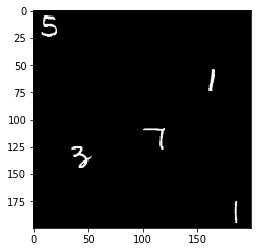

In [21]:
M = 200
image, coords, xlabel = make_image(X_test, y_test, M, H, W) # Construindo uma imagem para testes M x M com 4 dígitos
plot.imshow(image, cmap='gray');

## Aplicando classificador na imagem 200 x 200

In [22]:
in_image = image.astype(np.float32).reshape(1, 1, M, M) / 255.0  # Preparando a imagem para entrar na rede

img_hat_oh = model_B.predict(in_image)[0]  # Rede totalmente convolucional em execução
img_hat = softmax(img_hat_oh, axis=0)
# imagem das probabilidades máximas de cada pixel
pmax = img_hat.max(axis=0)
hm = np.zeros(np.array(pmax.shape)+6,np.float)
hm[3:-3, 3:-3] = pmax

### Imagem de probabilidade máxima de cada pixel referente a uma janela 28x28 (mapa de calor)

0.999996840954


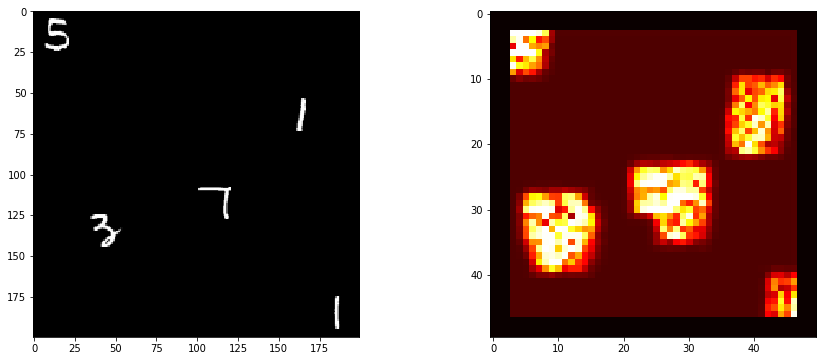

In [23]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(image, cmap='gray')

fig.add_subplot(1,2,2)
plot.imshow(hm, cmap=plot.cm.hot);
print(hm.max())

**Atenção:** Observe que as duas imagens acima possuem resolução (*shape*) diferentes. A resolução da imagem de entrada, mostrada à esquerda, é de (200,200) e a resolução da imagem de saída (à direita) é de (50,50).

## Aumentando a resolução para obter a mesma resolução da imagem de entrada

Observe que a cada janela de 4x4 pixels da imagem de entrada, existe um resultado na imagem de saída.

O objetivo agora é conseguir fazer com que a imagem resultante tenha o mesmo shape da imagem de entrada.

## Janela deslizante

Agora que temos uma rede toda convolucional, vejamos o que acontece se a imagem de entrada é maior que as imagens utilizadas para treinamento (28x28).

A figura abaixo, ilustra o processo mostrando as dimensões dos *features* através de uma linha da imagem de entrada com dimensões 36x36. Acompanhemos cada passo:

- imagem de entrada (representada na figura em uma dimensão apenas): 1x36x36;
- convolução 20 filtros 5x5, borda *'same'*: 20x36x36
- maxpool 2x2, stride 2x2: 20x18x18
- convolução 50 filtros 5x5, borda *'same'*: 50x18x18
- maxpool 2x2, stride 2x2: 50x9x9
- convolução 50 filtros 7x7, borda *'valid'*: 50x3x3
- convolução 10 filtros 1x1: 10x3x3

<table align='left'>
<!-- <tr><td> <img src="../figures/fully_conv_4.png" alt="Drawing" style="width: 200px;"/> </td> <td/></tr> -->
<tr><td colspan=2> <img src="../figures/fully_conv_3.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

### Demonstrando a técnica de *shift* e *stitch*

In [24]:
# Para demonstrar a técnica shift e stitch
def show_scan(M, H, W):
    from IPython import display
    def printt(arr):
        for line in output.tolist():
            print(' '.join([' abcdefghijklmnop'[x] for x in line]))

    M = 36
    image = np.zeros((1, 1, M, M))

    lab = 1
    output = np.zeros((M-H+1, M-W+1), np.uint8)
    for i in range(4):
        for j in range(4):
            oo = output[i::4, j::4]
            output[i::4, j::4] = lab * np.ones_like(oo)
            print('origin: ({}, {}), shape: {}, label: {}'.format(i, j, oo.shape, ' abcdefghijklmnop'[lab]))
            print()
            printt(output)
            lab += 1
            time.sleep(2)
            display.clear_output(wait=True)

In [25]:
show_scan(M, H, W) # Demonstração da varredura e preenchimento (shift, stitch)

origin: (3, 3), shape: (2, 2), label: p

a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a


## Rodando o classificador 16 vezes, preenchendo na forma shift-stitch

0 0 (10, 44, 44)
0 1 (10, 44, 43)
0 2 (10, 44, 43)
0 3 (10, 44, 43)
1 0 (10, 43, 44)
1 1 (10, 43, 43)
1 2 (10, 43, 43)
1 3 (10, 43, 43)
2 0 (10, 43, 44)
2 1 (10, 43, 43)
2 2 (10, 43, 43)
2 3 (10, 43, 43)
3 0 (10, 43, 44)
3 1 (10, 43, 43)
3 2 (10, 43, 43)
3 3 (10, 43, 43)
0.0 0.999998
(173, 173)


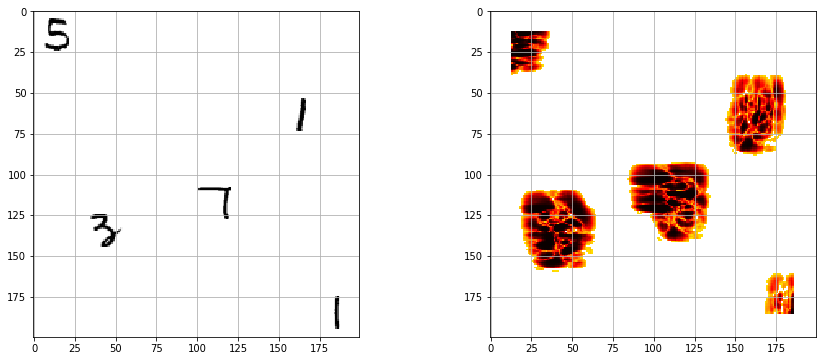

In [26]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(255 - image, cmap=plot.cm.gray)
plot.grid(True)

# Aplicando a técnica shift e stitch na imagem
# A rede convolucional é aplicada na imagem, 16 vezes para
# preencher os dados
output = np.zeros((10, M-H+1, M-W+1), np.float32)
for i in range(4):
    for j in range(4):
        output[:, i::4, j::4] = oo = model_B.predict(in_image[:, :, i:, j:])[0] # Execução da rede
        print(i, j, oo.shape)

output = softmax(output, axis=0)
pmax = output.max(0)
y_hat = output.argmax(0)
pmax = np.where(pmax < 0.3, 0, pmax)
print(pmax.min(), pmax.max())
print(pmax.shape)

pmax_img = np.zeros((M,M), pmax.dtype)
pmax_img[(H+1)//2-1:-H//2, (W+1)//2-1:-W//2] = pmax

y_hat_img = np.zeros((M,M), y_hat.dtype)
y_hat_img[(H+1)//2-1:-H//2, (W+1)//2-1:-W//2] = y_hat

fig.add_subplot(1,2,2)
plot.imshow(255 * (1.0 - pmax_img), cmap=plot.cm.hot)
# plot.imsave('heatmap.png', 255 * pmax)
plot.grid(True)

## Mostrando as probabilidades dos picos do mapa de calor

In [27]:
for k, (i, j) in zip(xlabel, coords):
    for m in (-1, 0, 1):
        for n in (-1, 0, 1):
            print('p = {:.5f}, char: \'{}\' [correct: \'{}\']'.format(pmax_img[i+m+13, j+n+13], 
                                                                      y_hat_img[i+m+13, j+n+13], k), end=' ')
            if m == n == 0:
                print('**')
            else:
                print()
    print()

p = 0.00000, char: '0' [correct: '5'] 
p = 0.00000, char: '0' [correct: '5'] 
p = 0.00000, char: '0' [correct: '5'] 
p = 0.00000, char: '0' [correct: '5'] 
p = 0.99987, char: '5' [correct: '5'] **
p = 0.97923, char: '5' [correct: '5'] 
p = 0.00000, char: '0' [correct: '5'] 
p = 0.99999, char: '5' [correct: '5'] 
p = 0.99926, char: '5' [correct: '5'] 

p = 0.80655, char: '1' [correct: '1'] 
p = 0.98375, char: '1' [correct: '1'] 
p = 0.98729, char: '1' [correct: '1'] 
p = 0.98792, char: '1' [correct: '1'] 
p = 0.99744, char: '1' [correct: '1'] **
p = 0.98921, char: '1' [correct: '1'] 
p = 0.99583, char: '1' [correct: '1'] 
p = 0.99840, char: '1' [correct: '1'] 
p = 0.92741, char: '1' [correct: '1'] 

p = 0.99998, char: '7' [correct: '7'] 
p = 0.99996, char: '7' [correct: '7'] 
p = 0.99995, char: '7' [correct: '7'] 
p = 0.99906, char: '7' [correct: '7'] 
p = 0.99819, char: '7' [correct: '7'] **
p = 0.99908, char: '7' [correct: '7'] 
p = 0.70245, char: '7' [correct: '7'] 
p = 0.75809, char

## Observações

- A rede base utilizada não foi treinada para a não-ocorrência de um dos dez caracteres, nem de recortes parciais dos caracteres originais.
- Um exercício interessante seria treinar o modelo com os caracteres sobrepostos a imagens de fundo, além de recortes do fundo sem caracter (11 classes).


## Aprendizados com este notebook
